## Localization Using Multiple RFID Tags

In this task, we try to localize a moving object using just 1 RFID reader antenna, but with multiple RFID tags. This is a more scalable solution, since RFID tags are extremely cheap and we can fix multiple tags to the object being localized.

The setup is as follows — an object is affixed with multiple RFID tags, as shown in the figure below. The relative positioning of the RFID tags on the object is measured apriori, and provided to you in the skeleton code where needed. Our goal here is to track the trajectory of the object as it moves. To this end, we move the object on some trajectory (marked by the black line in the figure (U shaped)). We collect phase measurements from the two tags as the object moves on the trajectory, and based on these phase measurements we estimate the trajectory of motion of the object. 

<img src="media/image5.png" alt="drawing" width="700"/> 


The core idea is as follows. When an RFID tag moves by some distance ∆d, the associated phase change observed at the RFID reader will be 4π∆d/λ (assuming no phase wrap takes place).
If we knew the initial position of the RFID reader with respect to the tag, then based on the phase change we can measure the new distance of the tag from the RFID reader (d + ∆d ). However, this information from a single tag is not sufficient to localize the reader since we do not have information about the relative direction. Therefore, we leverage this information from two tags, and estimate the relative position of the RFID reader using trilateration. If we perform this estimation across all successive points along the object’s trajectory, we can obtain the entire trajectory of the reader from the frame of reference of the object. Finally, we must rotate this trajectory using matrix multiplications, in order to retrieve the true trajectory of the object.

Your task in this lab is to implement the above system. We further break down this task into the following sub-tasks.


### Estimate change in distance
You must complete the functions `get_phase_change` and `variation_distance`. The `variation_distance` function should take as input the previous distance estimate, the observed phase change and the wavelength of the RF frequency. Based on these, it should output the new distance estimate after accounting for the phase change. In order to test this function, you must run the test cell below. This will save an output file to the Results folder. 

Moreover, you should plot the required results and submit them in your report. 

In [11]:
from utils import read_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

def get_phase_change(pha):
    pha_rad = np.deg2rad(pha)  # Convert degrees to radians (0 to π)
    pha_rad_doubled = pha_rad  # Scale to 0 to 2π radians
    pha_unwrapped = np.unwrap(pha_rad_doubled, period=np.pi)  # Unwrap phase
    pha_unwrapped_deg = np.rad2deg(pha_unwrapped)  # Convert back to degrees
    dpha = np.diff(pha_unwrapped_deg)  # Compute phase difference
    dpha = np.insert(dpha, 0, 0)  # Insert zero at the beginning
    return dpha

def variation_distance(distance_prev, phase_change, wavelength):
    ddist = phase_change * wavelength / (4*np.pi)
    distance_next = np.zeros(distance_prev.shape)


    distance_next = distance_prev + ddist
    return distance_next


C:\Users\mario\AppData\Local\Temp\ipykernel_5204\3036810047.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_next[k] = variation_distance(distance[k], phase_change[k], lambda_)


[[6.26995116 9.19283715 4.15336597 7.11692258 9.71063918 4.35650954
  6.3556629  9.01748234 8.71770826 1.4289372 ]] [6.27790868 9.20413467 4.16216512 7.12152935 9.71695484 4.36879216
 6.36478813 9.02145444 8.72520706 1.4418847 ]


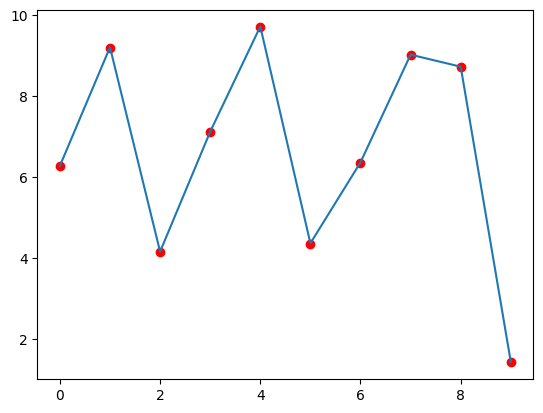

In [12]:
import numpy as np

import scipy.io as sio

# Load the MATLAB file
data = sio.loadmat('Test/Test_Dist_Variation.mat')
distance = data['distance'][0]
phase_change = data['phase_change'][0]
lambda_ = data['lambda'][0]

# Initialize the dist_next array
dist_next = np.zeros(100)

# Calculate the variation distance for each k
for k in range(100):

    dist_next[k] = variation_distance(distance[k], phase_change[k], lambda_)

plt.figure()
plt.plot(dist_next[0:10], label="Distance estimated")

debugging_data = sio.loadmat("Debugging_data/Dist_Variation_Results_10.mat")
debugging_data = debugging_data['dist_next']
plt.scatter(np.arange(0,10), debugging_data, color='red')
print(debugging_data, dist_next[0:10])

# Save the results to a MATLAB file
sio.savemat('Results/Dist_Variation_Results.mat', {'dist_next': dist_next})

### Trilateration

You must fill in the function `trilateration`. This code will take as input the coordinates of the two anchor points (RFID tag 1 and tag 2 in our case) in the 2D plane, and the corresponding distance of the RFID reader from the two anchor points. Based on these measurements, we will localize the RFID reader in the 2D plane. In order to test this function, you must run the trilateration test cell below. This will save an output file to the Results folder.

In [ ]:
def trilateration(anchor1, anchor2, dist_anchor1, dist_anchor2):
    import numpy as np
    import matplotlib.pyplot as plt


    x0, y0 = anchor1
    x1, y1 = anchor2
    r0 = dist_anchor1
    r1 = dist_anchor2

    # Compute the distance between the centers
    dx, dy = x1 - x0, y1 - y0
    d = np.hypot(dx, dy)

    # Check for solvability
    if d > r0 + r1:
        print("No intersection; the circles are separate.")
        return None
    if d < abs(r0 - r1):
        print("No intersection; one circle is contained within the other.")
        return None
    if d == 0 and r0 == r1:
        print("Infinite number of intersections; the circles are coincident.")
        return None

    # Find a and h
    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h = np.sqrt(r0**2 - a**2)

    # Find P2
    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d

    # Get the intersection points
    rx = -dy * (h / d)
    ry = dx * (h / d)

    xi1 = x2 + rx
    yi1 = y2 + ry
    xi2 = x2 - rx
    yi2 = y2 - ry

    # Plotting
    fig, ax = plt.subplots()
    circle1 = plt.Circle((x0, y0), r0, color='blue', fill=False)
    circle2 = plt.Circle((x1, y1), r1, color='red', fill=False)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.plot([xi1, xi2], [yi1, yi2], 'go')  # Intersection points
    ax.set_aspect('equal')
    ax.set_xlim(min(x0 - r0, x1 - r1) - 1, max(x0 + r0, x1 + r1) + 1)
    ax.set_ylim(min(y0 - r0, y1 - r1) - 1, max(y0 + r0, y1 + r1) + 1)
    plt.grid(True)
    plt.show()


    return (xi2,yi2) if yi2 > yi1 else (xi1,yi1)

In [41]:
import numpy as np

import scipy.io as sio

# Load the MATLAB file
data = sio.loadmat('Test/Test_Trilateration.mat')
anchor1 = data['anchor1'][0]
anchor2 = data['anchor2'][0]
radius1 = data['radius1'][0]
radius2 = data['radius2'][0]

# Initialize the position array
pos = np.zeros((10, 2))

# Perform trilateration for each data point
for k in range(10):
    pos[k, :] = trilateration(anchor1, anchor2, radius1[k], radius2[k])


debugging_data = sio.loadmat("Debugging_data/Trilateration_Results_5.mat")



assert np.allclose(debugging_data['pos'], pos[:5], atol=1e-6) , "The results are not correct"
# Save the results to a MATLAB file
sio.savemat('Results/Trilateration_results.mat', {'pos': pos})

### Trajectory Rotation

In the above two tasks, we are estimating the relative trajectory of the RFID reader from the frame of reference of the object. Therefore the above blocks will output a sequence of relative positions of the reader with respect to the object. However, in order to obtain the true trajectory of the object, we must invert this trajectory back to a stationary frame of reference.

This can be modeled as a simple matrix multiplication. That is, if we have a matrix `v` where the it `h` row of `v` denotes the relative `(x, y)` coordinate of the RFID reader at time `i` , then the true trajectory of the object can be obtained as ``v x R`` where `R` is a 2 × 2 matrix. In your report, you must derive the matrix `R`. You should use this matrix `R`, to complete the function invert_traj.

In order to evaluate the function, you should run the inverted trajectory test cell below. This will save an output file to the Results folder.

In [1]:
def invert_traj(traj):
    new_traj = np.zeros(traj.shape)

    return new_traj


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as sio

# Load the trajectory data
data = sio.loadmat('Test/Test_trajectory_inversion.mat')
traj = data['traj']

# Invert the trajectory
traj_new = invert_traj(traj)

# Plot the original and inverted trajectories
fig, ax = plt.subplots()
ax.plot(traj[:, 0], traj[:, 1], linewidth=4, label='Relative Trajectory')
ax.plot(traj_new[:, 0], traj_new[:, 1], linewidth=4, label='Ground Frame Trajectory')
ax.legend()
ax.set_title('Trajectory Inversion Results')

# Save the figure and trajectory data
plt.savefig('Results/Result_trajectory_inversion.png')
sio.savemat('Results/Result_trajectory_inversion.mat', {'traj_new': traj_new})

### Estimate Trajectory 

Now that we have all the blocks ready, we can use them to track trajectory of the object. We col lect phase measurements from the RFID tags as the object moves on the trajectory, and provide
them in the data file `Lab_Data/lab3_task4.txt`. You will process this data to estimate the relative trajectory of the reader, and further obtain the true trajectory of the object. 


The code for this subpart should be written in the cell below. The script should call the functions that you implemented in the previous sub-parts. The skeleton code provides you with all the measurements you need, such as the initial position of the RFID reader relative to the tags, the relative positioning of the RFID tags on the object, and the shape and dimensions of the ground truth trajectory of the object

In [ ]:

# Assuming the functions read_data, get_phase_change, variation_distance, trilateration, invert_traj are already defined.

# Read the data file
file = 'Lab_Data/lab3_task4.txt'
channel_log = read_data(file)


# Extract and process the data
epc = channel_log['EPC'].astype(str).values
freq = channel_log['Frequency'].iloc[0] * 1e3
pha = channel_log['Phase'].astype(float).values
time = (channel_log['hour'] * 60 + channel_log['minute']) * 60 + channel_log['second'] + channel_log['nanosecond'] * 1e-9
time = time - time[0]

lambda_ = 3e8 / freq
d = 7.62e-2

anchorl = np.array([-d, 0])
anchorr = np.array([d, 0])

# Relative trace
pos = np.zeros((len(time), 2))
pos[0, :] = [1.12e-1, 8.33e-1]

# Phase change

# TODO: Plot phase unwrapping


# TODO: Plot phase changes

# Distance changes


# TODO: Plot distances


# Position changes

# TODO: show trace


# TODO: show Static trace


# Measured trace
